# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date:  2023**

# Notebook 3A. WSB posts labelling using trained model

## 2.0 Imports

In [155]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD

# Pipeline Utilities
from sklearn.pipeline import Pipeline, make_pipeline

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

# Serialization/Deserialization Libraries
from joblib import dump
import dill as pickle

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

# Set the global font to be used for all text
plt.rcParams['font.family'] = 'Gill Sans'  

In [156]:
df_all = pd.read_csv('../data/02_reddit_cleaned_slim.csv')

In [157]:
#df_all = df_all.sample(300000).copy()
# df = df_all.copy()

In [158]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103512 entries, 0 to 1103511
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   id                   1103512 non-null  object 
 1   author               1103506 non-null  object 
 2   created              1103506 non-null  object 
 3   removed              1103506 non-null  float64
 4   deleted              1103506 non-null  float64
 5   is_self              1103506 non-null  float64
 6   is_video             1103506 non-null  float64
 7   link_flair_text      1103506 non-null  object 
 8   upvote_ratio         1103506 non-null  float64
 9   score                1103506 non-null  float64
 10  num_comments         1103506 non-null  float64
 11  shortlink            1103506 non-null  object 
 12  FolderName           1103506 non-null  object 
 13  word_count_selftext  1103506 non-null  float64
 14  word_count_title     1103506 non-null  float64
 15

In [159]:
# Convert 'title' column to string
df_all['Text'] = df_all['Text'].astype(str)

# Convert 'date' column to datetime
df_all['date'] = pd.to_datetime(df_all['date'])

# Filter out rows where 'title' starts with 'Daily '
df_all = df_all[~df_all['Text'].str.startswith('Daily ')].copy()
df_all = df_all[~df_all['Text'].str.startswith('Market Events')].copy()

print(df_all.shape)

(1102512, 17)


In [160]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1102512 entries, 0 to 1103511
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1102512 non-null  object        
 1   author               1102506 non-null  object        
 2   created              1102506 non-null  object        
 3   removed              1102506 non-null  float64       
 4   deleted              1102506 non-null  float64       
 5   is_self              1102506 non-null  float64       
 6   is_video             1102506 non-null  float64       
 7   link_flair_text      1102506 non-null  object        
 8   upvote_ratio         1102506 non-null  float64       
 9   score                1102506 non-null  float64       
 10  num_comments         1102506 non-null  float64       
 11  shortlink            1102506 non-null  object        
 12  FolderName           1102506 non-null  object        
 13  wo

In [161]:
# Selecting only the 'id', 'title', and 'selftext' columns
#df = df_all[['id', 'Text']].copy()
df = df_all.copy()

In [162]:
df.sample(5)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,num_comments,shortlink,FolderName,word_count_selftext,word_count_title,date,Text
579838,l4onnq,skygong21,2021-01-25 14:15:15,1.00,0.00,1.00,0.00,Discussion,1.00,1.00,1.00,https://redd.it/l4onnq,wallstreetbets,1.00,4.00,2021-01-25,Why is banned? [removed]
911464,qwwhqe,FumyLikes,2021-11-18 18:42:40,1.00,0.00,1.00,0.00,none,1.00,1.00,0.00,https://redd.it/qwwhqe,investing,1.00,11.00,2021-11-18,Is this a good approach to begin my long-term investment strategy? [removed]
469383,lvkc6g,Kacpereek,2021-03-01 20:57:55,0.00,0.00,0.00,0.00,Memes,0.69,7.00,1.00,https://redd.it/lvkc6g,gme,1.00,23.00,2021-03-01,"Dance with me, do whatever the fuck you want, but don't dare to sell you lovely apes. To the moon we go! 🚀"
915380,r6ksq4,Freesouldude,2021-12-01 17:59:16,1.00,0.00,1.00,0.00,Discussion,1.00,1.00,0.00,https://redd.it/r6ksq4,stockmarket,1.00,5.00,2021-12-01,Apple 🍎 🚀🎯 next AMC? [removed]
8347,ls6e6f,Holdfromspain,2021-02-25 13:18:52,0.00,0.00,0.00,1.00,Meme,0.98,5068.00,186.00,https://redd.it/ls6e6f,wallstreetbets,1.00,9.00,2021-02-25,GME IS BACK!!! GROUND CONTROL TO MAJOR TOM!!! 🚀🚀🚀💎💎💎


In [163]:
df.shape

(1102512, 17)

## 2.1. Cleaning the text (pre-processing)

In [164]:
# punctuation and anything except for letters is stripped away, also empty spaces go away. 

# Emojis are stripped off!!!! NB! 

if False:
    
    cleaned_df = df.copy()
    # to replace any character that is not a lowercase or uppercase letter with a single space
    # then to replace one or more whitespace characters (\s+) with a single space
    # then to replace '/n' with empty spaces
    # then to remove all types of whitespace characters at the ends of the string
    # cleaned_df["Text"] = cleaned_df["Text"].replace("\n", "").str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")


    # First, replace newline characters with an empty string for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace("\n", "", regex=False)

    # Then, replace non-alphabetic characters with a space for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace(r"[^a-zA-Z]", " ", regex=True)

    # Then, replace multiple spaces with a single space for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace(r"\s+", " ", regex=True)

    # Finally, strip leading and trailing spaces from each element
    cleaned_df["Text"] = cleaned_df["Text"].str.strip()

    df=cleaned_df.copy()

I am going to exclude information and unclear from the dataset. negative will be assugned rating 0, and positive will be assigned trating 1.  

### 2.1.1. Custom Tokenization function

In [199]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'game', 'amc', 'nok', 'bb', 'spy']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [166]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

## 2.2. Relevant or not model

In [167]:
import joblib
# Load the pipelineon relevance
pipeline_loaded_rel = joblib.load('../model/03_A_best_pipeline_irrelevant.pkl')

In [168]:
# Predicting new data based on Text

# Assign new X variable 
X_new = df['Text']

# Apply the relevance pipeline to the WSB dataset
predictions_rel = pipeline_loaded_rel.predict(X_new)

In [169]:
# Review and process predictions

pbb_rel = pipeline_loaded_rel.predict_proba(X_new)
df['Probab_not_rel']= pbb_rel[:,0]
df['Probab_yes_rel']= pbb_rel[:,1]
df['Post Relevance'] = predictions_rel

#df.to_csv('../data/predictions_yes_no.csv', index=False)

In [170]:
df.sample(2)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,num_comments,shortlink,FolderName,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance
883616,lodpd2,Currie32,2021-02-20 18:46:57,1.00,0.00,1.00,0.00,none,1.00,1.00,0.00,https://redd.it/lodpd2,stocks,1.00,9.00,2021-02-20,How do you evaluate the management of a company? [removed],0.90,0.10,0
783506,l6gm7l,Pharmdstuff,2021-01-27 22:45:08,1.00,0.00,1.00,0.00,Discussion,1.00,1.00,0.00,https://redd.it/l6gm7l,wallstreetbets,1.00,4.00,2021-01-27,Late to the party? [removed],0.67,0.33,0


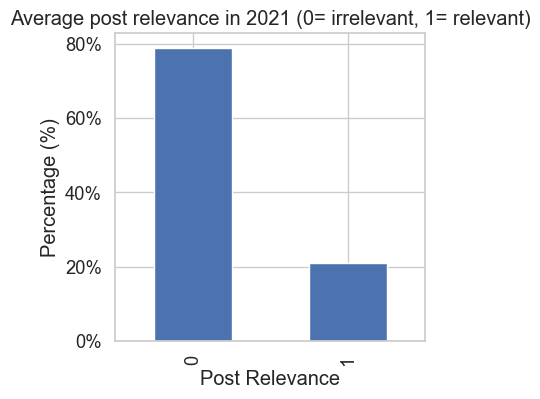

In [200]:
# Calculate the value counts and convert to percentages
value_counts = df['Post Relevance'].value_counts(normalize=True).sort_index() * 100

# Plotting the percentages
ax = value_counts.plot(kind='bar',
                       title='Average post relevance in 2021 (0= irrelevant, 1= relevant)',
                       figsize=(4, 4))

# Set the x-label
ax.set_xlabel('Post Relevance')

# Set the y-label to indicate percentages
ax.set_ylabel('Percentage (%)')

# Optional: Format y-axis ticks as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.show()

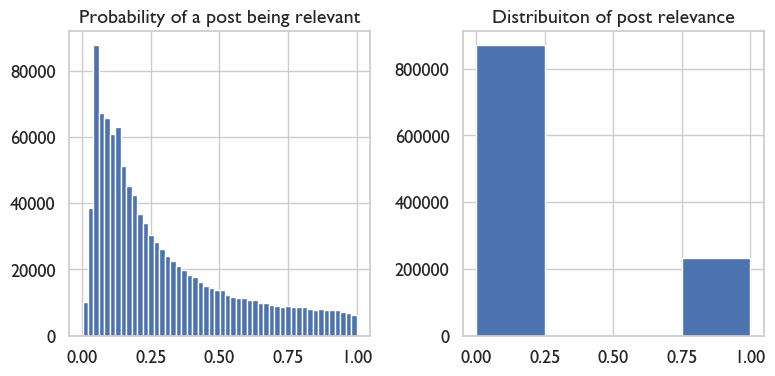

In [212]:
# Plotting the histograms
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Probability of a post being relevant')
plt.hist(df['Probab_yes_rel'], bins=50)

plt.subplot(1, 2, 2)
plt.title('Distribuiton of post relevance')
plt.hist(df['Post Relevance'], bins=4)

plt.tight_layout()
plt.show()


In [173]:
print(pipeline_loaded_rel.named_steps.keys())

# Extract the model from the pipeline
model = pipeline_loaded_rel.steps[-1][1]

# Replace 'correct_step_name' with the actual step name you found
vectorizer = pipeline_loaded_rel.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()

print(len(model.coef_[0]))
print(len(feature_names))

dict_keys(['tfidf', 'logr'])
79301
79301


In [174]:
# Extracting model coefficients:
if hasattr(model, 'coef_'):
    # Extract feature names
    vectorizer = pipeline_loaded_rel.named_steps['tfidf']  
    feature_names_rel = vectorizer.get_feature_names_out()

    # Storing the coefficients
    coef_df_rel = pd.DataFrame({
        "coefficient": model.coef_[0],
        "token": feature_names
    })

    # Sort by coefficients
    coef_df_rel = coef_df_rel.sort_values("coefficient", ascending=False)

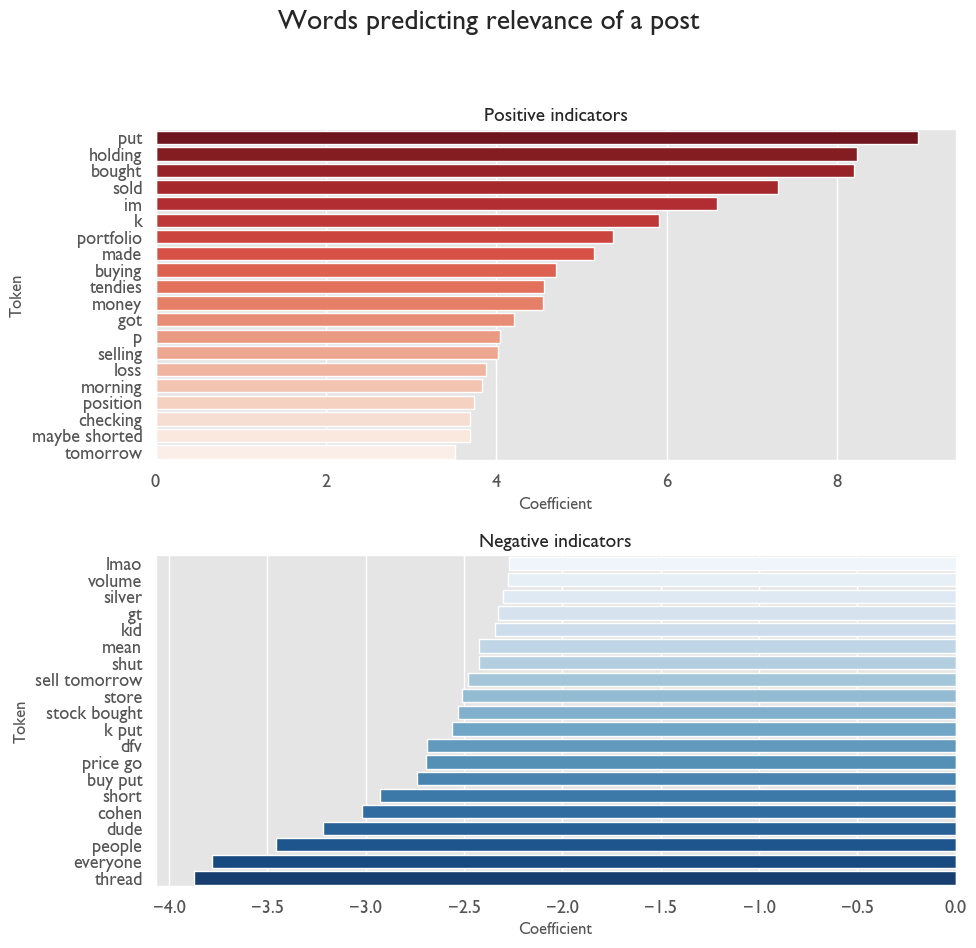

In [175]:
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Setting the overall figure title with a specific font
    fig.suptitle('Words predicting relevance of a post', fontsize=20, fontname='Gill Sans')

    # Setting up the Seaborn style
    sns.set(style="whitegrid", font_scale=1.2)

    # Plot tokens with largest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df_rel.head(20), ax=axs[0], palette="Reds_r")
    axs[0].set_title("Positive indicators", fontsize=14)
    axs[0].set_xlabel("Coefficient")
    axs[0].set_ylabel("Token")

    # Plot tokens with smallest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df_rel.tail(20), ax=axs[1], palette="Blues")
    axs[1].set_title("Negative indicators", fontsize=14)
    axs[1].set_xlabel("Coefficient")
    axs[1].set_ylabel("Token")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 

    plt.show()

## 2.2. Yes and No Model (Buy and Sell predictions)

In [176]:
# Load the entire pipeline from the file
pipeline_loaded = joblib.load('../model/03_A_best_pipeline_yes_no.pkl')

In [177]:
# Predicting BUY and SELL sentiment 
# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

In [178]:
# Review and process BUY and SELL predictions 

pbb = pipeline_loaded.predict_proba(X_new)
df['Prob SELL']= pbb[:,0]
df['Prob BUY']= pbb[:,1]
df['BUY SELL categories'] = predictions

#df.to_csv('../data/predictions_yes_no.csv', index=False)

In [179]:
df.sample(3)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
21949,o15oec,cheetoMcGee,2021-06-16 14:05:11,0.00,0.00,0.00,0.00,Loss,0.74,200.00,...,1.00,14.00,2021-06-16,"WKHS Double Down, Tripple Loss! Where do I get my 💎🤲🦍 Retard Certification? 😅",0.51,0.49,0,0.45,0.55,1
111513,lcm8qd,TheProphetsGambit,2021-02-04 18:24:39,0.00,0.00,1.00,0.00,Discussion,0.86,21.00,...,10.00,6.00,2021-02-04,$BB Bruised Berry Bagholder Support Group A safe place for Bagholders and Sackholders to talk 🌈,0.67,0.33,0,0.77,0.23,0
709712,m4myws,milelom,2021-03-14 03:35:51,1.00,0.00,0.00,0.00,Discussion,1.00,6.00,...,1.00,23.00,2021-03-14,"I am in......Apes helping Apes, We will leave no APES behind, we will pick them all up and take them to the MOON.......",0.61,0.39,0,0.01,0.99,1


In [202]:
relevant = df[df['Probab_yes_rel'] > 0.5]
relevant.sample(3)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
1053849,l6zlp3,[deleted],2021-01-28 15:25:25,1.00,0.00,1.00,0.00,YOLO,0.99,3.00,...,1.00,11.00,2021-01-28,Late to party $1k up to $100 down to $400 up [removed],0.28,0.72,1,0.15,0.85,1
51696,l2x4gb,squarexu,2021-01-22 21:09:56,0.00,0.00,1.00,0.00,Gain,0.91,166.00,...,63.00,8.00,2021-01-22,"Using 8% GME ownership, WSB has made ~250MMM Rough calc...at share price 20, GME has appreciated 3.25 times.Market Cap of GME at 20 was 1.385B, or our position was about 110M. Now that position is worth around 360M or gain of 250MMM for this sub. I propose we declare Jan 22 GME day at WSB or something....Before we can move sub 2B stocks....now we can go for 10B plus companies.",0.40,0.60,1,0.98,0.02,0
353355,qbzcjb,Ayy_Katt,2021-10-20 12:08:57,1.00,0.00,0.00,0.00,Loss,0.50,0.00,...,1.00,18.00,2021-10-20,Is Tax-Trade legit? A friend just made $1200 in profit but the site wants $600 to cash out?,0.27,0.73,1,0.08,0.92,1


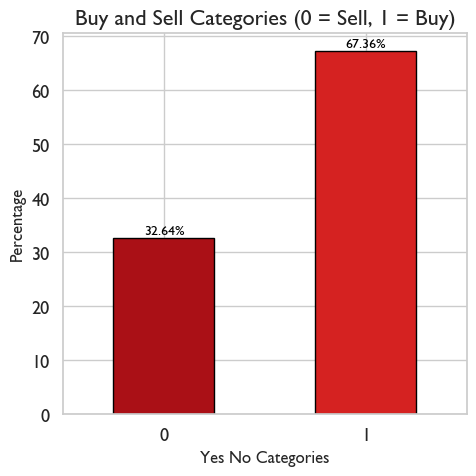

In [213]:
plt.rcParams['font.family'] = 'Gill Sans'

# Calculate the percentage values
total_count = len(relevant)
percentages = relevant['BUY SELL categories'].value_counts(normalize=True).sort_index() * 100

# plot the data 
ax = percentages.plot(kind='bar',
                      color=sns.color_palette("Reds_r"),
                      edgecolor='black',
                      figsize=(5, 5))

ax.set_title('Buy and Sell Categories (0 = Sell, 1 = Buy)', fontsize=16)
ax.set_xlabel('Yes No Categories', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)

ax.tick_params(axis='x', labelrotation=0)

# Annotate the bars with percentages
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

### 2.3. Analysing the predictions

In [182]:
buys = relevant[relevant['Prob BUY'] > 0.5]
buys.sample(3)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
528030,mkbo52,josecvillanueva,2021-04-05 03:29:42,0.00,0.00,1.00,0.00,💎🙌,1.00,16.00,...,53.00,3.00,2021-04-05,Valar Shortghulis 🪙 “All shorts must cover”It’s high Valyrian for the one and only piece of DD we’ve ever needed.They can take the buy button away.They can take our subreddit away.They can take our beloved mods away.They can take damn near everything..EXCEPT MY SHARES.BUY AND HODL! Not financial advice.,0.40,0.60,1,0.04,0.96,1
170851,qmr2y2,JackBanks17,2021-11-04 18:25:58,0.00,0.00,0.00,0.00,Gain,0.92,32.00,...,1.00,13.00,2021-11-04,$NVDA Biggest gain so far and still holding. Til Valhalla or Wendy's! 🚀🚀💥,0.20,0.80,1,0.01,0.99,1
116591,l72613,[deleted],2021-01-28 16:55:29,1.00,1.00,0.00,0.00,Loss,0.86,28.00,...,1.00,34.00,2021-01-28,Bought 12 shares of AMC yesterday as a poor. Class solidarity. Let’s make them pay. I don’t even care about the money this is the most optimistic I’ve been in YEARS. Nothing to lose. [deleted],0.08,0.92,1,0.02,0.98,1


In [183]:
# Examining the SELL recommendations
sells = relevant[relevant['Prob BUY'] < 0.5]
sells.sample(1)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
890585,laekux,Every-Development398,2021-02-01 21:24:01,0.00,0.00,1.00,0.00,none,0.76,4.00,...,67.00,6.00,2021-02-01,"Anyone else having trouble with ally? Some very odd things happening, got a margin call on a none margin account. They are also restricting buying certain stocks like BB and GME.Called today was basically told by the customer service we cannot help you with your account. When asking why they said they cannot tell me wtf?&anyone else having trouble with them...&starting to think ally is not an ally.",0.20,0.80,1,0.94,0.06,0


### Extracting model coefficients from the pickled model

In [184]:
print(pipeline_loaded.named_steps.keys())

# Extract the model from the pipeline
model = pipeline_loaded.steps[-1][1]

# Replace 'correct_step_name' with the actual step name you found
vectorizer = pipeline_loaded.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()

print(len(model.coef_[0]))
print(len(feature_names))

dict_keys(['tfidf', 'logr'])
34914
34914


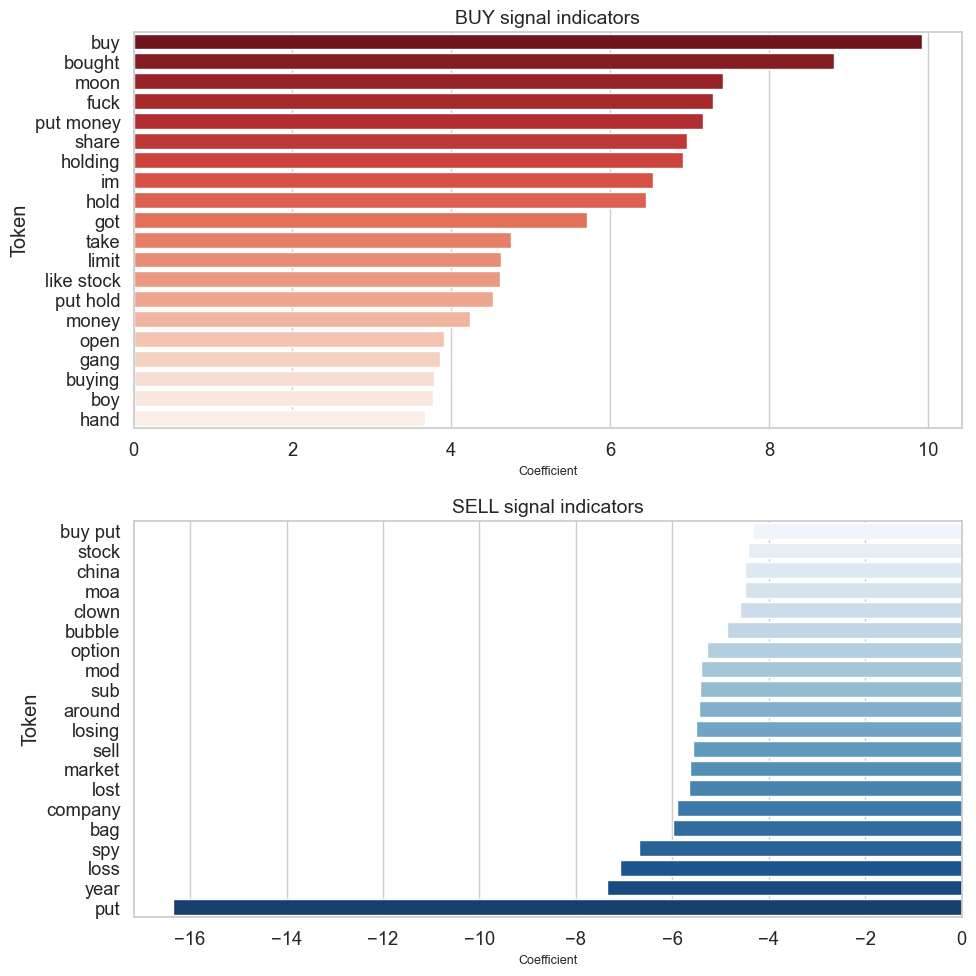

In [185]:
if hasattr(model, 'coef_'):
    # Extract feature names
    vectorizer = pipeline_loaded.named_steps['tfidf']  
    feature_names = vectorizer.get_feature_names_out()

    # Storing the coefficients
    coef_df = pd.DataFrame({
        "coefficient": model.coef_[0],
        "token": feature_names
    })

    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Setting up the Seaborn style
    sns.set(style="whitegrid", font_scale=1.2)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot tokens with smallest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df.head(20), ax=axs[0], palette="Reds_r")
    axs[0].set_title("BUY signal indicators", fontsize=14)
    axs[0].set_xlabel("Coefficient",fontsize=9)
    axs[0].set_ylabel("Token")

    # Plot tokens with largest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df.tail(20), ax=axs[1], palette="Blues")
    axs[1].set_title("SELL signal indicators", fontsize=14)
    axs[1].set_xlabel("Coefficient", fontsize=9)
    axs[1].set_ylabel("Token")

    fig.tight_layout()
    plt.show()
else:
    print("The model does not have coefficients to extract.")


In [186]:
df.to_csv('../data/04_Reddit_model_applied_results.csv', index=False)

In [187]:
import matplotlib.font_manager

fonts = sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))
for font in fonts:
    print(font)


.Aqua Kana
.Keyboard
.New York
.SF Arabic
.SF Arabic Rounded
.SF Compact
.SF Compact Rounded
.SF NS Mono
.SF NS Rounded
.ThonburiUI
Academy Engraved LET
Al Bayan
Al Nile
Al Tarikh
American Typewriter
Andale Mono
Apple Braille
Apple Chancery
Apple SD Gothic Neo
Apple Symbols
AppleGothic
AppleMyungjo
Arial
Arial Black
Arial Hebrew
Arial Narrow
Arial Rounded MT Bold
Arial Unicode MS
Athelas
Avenir
Avenir Next
Avenir Next Condensed
Ayuthaya
Baghdad
Bangla MN
Bangla Sangam MN
Baskerville
Beirut
Big Caslon
Bodoni 72
Bodoni 72 Oldstyle
Bodoni 72 Smallcaps
Bodoni Ornaments
Bradley Hand
Brush Script MT
Chalkboard
Chalkboard SE
Chalkduster
Charter
Cochin
Comic Sans MS
Copperplate
Corsiva Hebrew
Courier
Courier New
DIN Alternate
DIN Condensed
Damascus
DecoType Naskh
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif Display
Devanagari MT
Devanagari Sangam MN
Didot
Diwan Kufi
Diwan Thuluth
Euphemia UCAS
Farah
Farisi
Futura
Galvji
Geeza Pro
Geneva
Georgia
Gill Sans
Gujarati 

## 2.2. No only

## 2.x. Analysing the ratings distribution

In [188]:
# Saving the dataset for further work in Notebook X

# df.to_csv('../data/dataset_bull_bear.csv', index=False)

## 5.X. Grouping by author

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1102512 entries, 0 to 1103511
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1102512 non-null  object        
 1   author               1102506 non-null  object        
 2   created              1102506 non-null  object        
 3   removed              1102506 non-null  float64       
 4   deleted              1102506 non-null  float64       
 5   is_self              1102506 non-null  float64       
 6   is_video             1102506 non-null  float64       
 7   link_flair_text      1102506 non-null  object        
 8   upvote_ratio         1102506 non-null  float64       
 9   score                1102506 non-null  float64       
 10  num_comments         1102506 non-null  float64       
 11  shortlink            1102506 non-null  object        
 12  FolderName           1102506 non-null  object        
 13  wo

In [190]:
# Excluding object columns and aggregating by day
df_numerical = df.select_dtypes(include=[np.number])

# Grouping by day and averaging numerical columns
df_agg_by_day = df_numerical.groupby(df['date'].dt.date).mean()
df_agg_by_day.head() 

,removed,deleted,is_self,is_video,upvote_ratio,score,num_comments,word_count_selftext,word_count_title,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
date,,,,,,,,,,,,,,,
2021-01-01,0.72,0.21,0.64,0.03,0.86,90.76,53.47,36.59,9.80,0.66,0.34,0.27,0.42,0.58,0.62
2021-01-02,0.74,0.17,0.66,0.03,0.87,102.50,17.16,44.30,8.58,0.68,0.32,0.22,0.43,0.57,0.61
2021-01-03,0.74,0.16,0.68,0.03,0.86,138.03,16.42,59.82,8.66,0.66,0.34,0.26,0.44,0.56,0.61
2021-01-04,0.77,0.17,0.65,0.03,0.88,68.71,11.20,30.24,8.72,0.67,0.33,0.25,0.41,0.59,0.63
2021-01-05,0.73,0.16,0.67,0.03,0.88,57.30,13.08,31.86,8.53,0.68,0.32,0.23,0.41,0.59,0.64


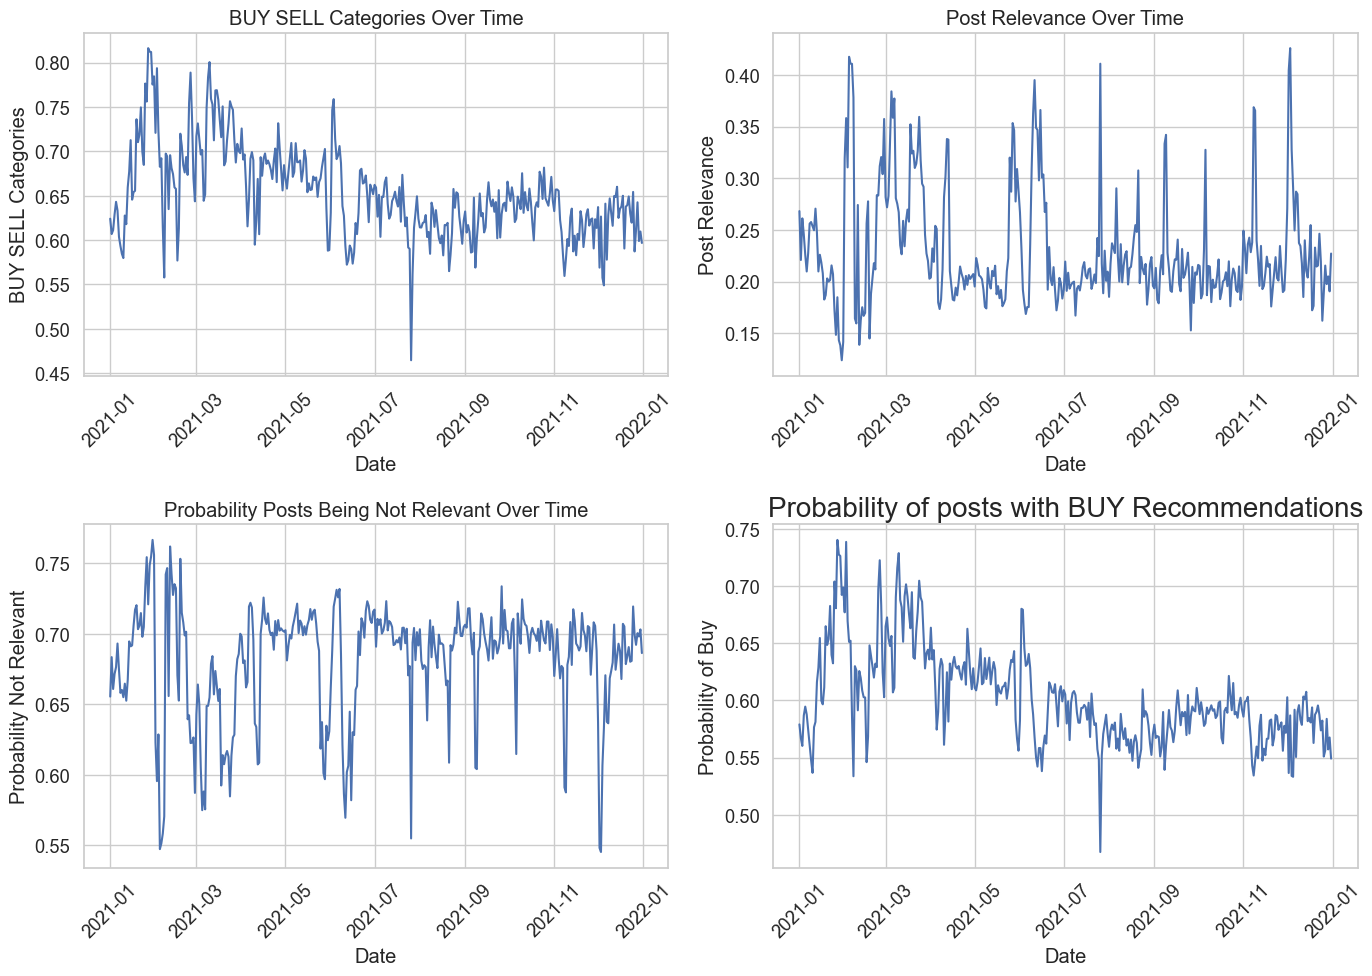

In [198]:
# Preparing 4 charts and placing them as subplots in a 2 by 2 grid

# Setting up the figure for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plotting each field in a separate subplot
sns.lineplot(ax=axes[0, 0], data=df_agg_by_day, x=df_agg_by_day.index, y='BUY SELL categories')
axes[0, 0].set_title('BUY SELL Categories Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('BUY SELL Categories')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.lineplot(ax=axes[0, 1], data=df_agg_by_day, x=df_agg_by_day.index, y='Post Relevance')
axes[0, 1].set_title('Post Relevance Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Post Relevance')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.lineplot(ax=axes[1, 0], data=df_agg_by_day, x=df_agg_by_day.index, y='Probab_not_rel')
axes[1, 0].set_title('Probability Posts Being Not Relevant Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Probability Not Relevant')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.lineplot(ax=axes[1, 1], data=df_agg_by_day, x=df_agg_by_day.index, y='Prob BUY')
axes[1, 1].set_title('Probability of posts with BUY Recommendations', fontsize=20)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Probability of Buy')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [192]:
# Group by the 'author' column and aggregate other columns
df_agg_by_author = df.groupby([df['author']]).agg({
    'id':'count', 
    'score': 'mean',
    'num_comments':'sum',
    'deleted':'sum',
    'removed':'sum',
    'upvote_ratio':'sum',
    'Probab_not_rel':'mean',
    'Probab_yes_rel':'mean',
    'Post Relevance':'mean',
    'Prob SELL':'mean',
    'Prob BUY':'mean',
    'BUY SELL categories':'mean'
    #'word_count':'mean'
}).reset_index().rename(columns={
    'id': 'total_posts',
    'score': 'average_score',
    'num_comments': 'total_comments',
    'deleted':'total_deleted',
    'removed':'total_removed',
    'upvote_ratio':'total_upvote_ratio',
    'Probab_not_rel':'aver prob irrel',
    'Probab_yes_rel':'aver prob relev',
    'Post Relevance':'percent relevant',
    'Prob SELL':'aver prob SELL',
    'Prob BUY':'aver prob BUY',
    'BUY SELL categories':'Aver bullishness'
    #'word_count':'aver word count'
})

In [193]:
df_agg_by_author_sorted = df_agg_by_author.sort_values(by='average_score', ascending=False)
df_agg_by_author_sorted.head(20)

,author,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,aver prob irrel,aver prob relev,percent relevant,aver prob SELL,aver prob BUY,Aver bullishness
5530,84935,1,204095.00,5846.00,0.00,0.00,0.96,0.93,0.07,0.00,0.21,0.79,1.00
423137,string_beans,1,167635.00,4274.00,0.00,0.00,0.92,0.93,0.07,0.00,0.15,0.85,1.00
377722,mcuban,1,154745.00,27424.00,0.00,0.00,0.89,0.82,0.18,0.00,0.07,0.93,1.00
141557,Lansman,1,107107.00,3332.00,0.00,0.00,0.93,0.22,0.78,1.00,0.09,0.91,1.00
65159,DeepFuckingValue,17,106921.29,141340.00,0.00,0.00,15.74,0.61,0.39,0.06,0.45,0.55,0.76
285190,_saucy_balloon,1,106819.00,2132.00,0.00,0.00,0.93,0.82,0.18,0.00,0.01,0.99,1.00
449971,zakaria20199,1,103096.00,3730.00,0.00,0.00,0.97,0.90,0.10,0.00,0.99,0.01,0.00
44568,CaptainOats8690,1,99779.00,5661.00,0.00,0.00,0.69,0.17,0.83,1.00,0.02,0.98,1.00
313354,conciselouis,1,98210.00,4553.00,0.00,0.00,0.90,0.91,0.09,0.00,0.09,0.91,1.00
198799,Primordial_Hatred,1,98013.00,3773.00,0.00,0.00,0.88,0.92,0.08,0.00,0.10,0.90,1.00


In [194]:
# Sorting the filtering results by the AVERAGE SCORE
df_agg_by_author_sorted['total_pct_removed'] = df_agg_by_author_sorted['total_removed'] / df_agg_by_author['total_posts'] *100

df_authors= df_agg_by_author_sorted.sort_values(by='total_pct_removed', ascending=False).head(100)
df_authors.head(10)

,author,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,aver prob irrel,aver prob relev,percent relevant,aver prob SELL,aver prob BUY,Aver bullishness,total_pct_removed
343987,henny669,1,1.00,0.00,0.00,1.00,1.00,0.64,0.36,0.00,0.05,0.95,1.00,100.00
133475,Juststellar,4,1.00,1.00,0.00,4.00,4.00,0.46,0.54,0.75,0.76,0.24,0.00,100.00
133481,Justtryinganything,1,1.00,1.00,0.00,1.00,1.00,0.68,0.32,0.00,0.59,0.41,0.00,100.00
133482,Justtrynagetrichtoo,1,1.00,0.00,0.00,1.00,1.00,0.79,0.21,0.00,0.07,0.93,1.00,100.00
133483,Justtrynamakeit95,1,1.00,0.00,0.00,1.00,1.00,0.55,0.45,0.00,0.07,0.93,1.00,100.00
133484,Justtrynamakeit98,1,1.00,2.00,0.00,1.00,1.00,0.95,0.05,0.00,0.39,0.61,1.00,100.00
133486,Justuraveragejim,2,1.00,2.00,0.00,2.00,2.00,0.68,0.32,0.50,0.61,0.39,0.50,100.00
133488,Justvibingbro94,1,1.00,0.00,0.00,1.00,1.00,0.95,0.05,0.00,0.39,0.61,1.00,100.00
133490,Justwaitingonmymoney,3,1.00,5.00,0.00,3.00,3.00,0.93,0.07,0.00,0.43,0.57,0.67,100.00
133491,Justwanttosavebuddy,1,1.00,0.00,0.00,1.00,1.00,0.90,0.10,0.00,0.30,0.70,1.00,100.00


Seeing a lot of bots, where 100% of their posts have been deleted by the moderators. I want to drop those spammers from my analysis. The code below shows that 63.6% of authors were actually spammers. This leaves me with a substantially smaller number of authors (163,768).

In [195]:
# Calculating how many rows will be dropped if I deleted all the authors where 100% of their posts have been removed by the moderators
rows_to_drop = df_agg_by_author[df_agg_by_author['total_pct_removed'] == 100].shape[0]
print(f"Number of rows to be dropped: {rows_to_drop}")

total_authors = df_agg_by_author.shape[0]
percentage_to_drop = (rows_to_drop / total_authors) * 100
print(f"Percentage of authors to be dropped: {percentage_to_drop:.2f}%")

KeyError: 'total_pct_removed'

In [ ]:
# Dropping rows with spammers (where 100% of their posts have been removed by moderators) 
# Keep rows where 'total_pct_removed' is less than 100
df_agg_by_author = df_agg_by_author[df_agg_by_author['total_pct_removed'] < 100]

KeyError: 'total_pct_removed'

In [ ]:
# Sorting the filtering results by the AVERAGE SCORE
df_authors= df_agg_by_author.sort_values(by='sum_yes_only_title', ascending=False).head(10)
df_authors.head(10)

KeyError: 'sum_yes_only_title'

In [ ]:
df.columns

In [ ]:
df_agg_by_author.describe()